In [22]:
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.transform import resize
from skimage.filters import threshold_otsu
import cv2
from Utils import *

In [23]:
color_channels = 3
pixel_depth = 255.0
bbox_horz_exp = 1  # Pixels to expand bounding boxes by in each horizontal direction

**Preprocess images**

In [24]:
def import_bboxes(path):
    path = data_dir + path
    mat = h5py.File(path + '/digitStruct.mat', 'r')
    dig = mat['digitStruct']
    bbox = dig['bbox']
    keys = dig[bbox[0, 0]].keys()
    data = {k: [] for k in keys}
    n_samples = bbox.shape[0]
    data['n_digits'] = [dig[bbox[i, 0]]['label'][()].shape[0] for i in range(n_samples)]
    for key in keys:
        res = []
        for i in range(n_samples):
            n_digs = data['n_digits'][i]
            ds = [dig[bbox[i, 0]][key][()][j, 0] for j in range(n_digs)]
            if n_digs != 1:
                ds = [int(mat[d][()][0, 0]) for d in ds]
            else:
                ds = [int(d) for d in ds]
            data[str(key)].append(ds)
    return n_samples, data
def import_images(path, n_images):
    path = data_dir + path
    images = []
    for i in range(1, n_images + 1):
        img = (ndimage.imread(path + '/' + str(i) + '.png').astype(float) - pixel_depth / 2) / pixel_depth
        images.append(img)
        if i % 10 == 0:
            sys_pr('\rImported image ' + str(i))
    print()
    return images
def local_contrastive_norm(img):
    img = deepcopy(img)
    img += 0.5
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    float_gray = gray.astype(np.float32) / 255.0
    blur = cv2.GaussianBlur(float_gray, (0, 0), sigmaX=2, sigmaY=2)
    num = float_gray - blur
    blur = cv2.GaussianBlur(num*num, (0, 0), sigmaX=25, sigmaY=25)
    den = cv2.pow(blur, 0.5)
    gray = num / den
    cv2.normalize(gray, dst=gray, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    return gray - 0.5
def extract_digits(images, bboxes, dims=(14, 29)):
    new_n = sum(bboxes['n_digits'])
    digh, digw = dims
    digw += bbox_horz_exp * 2
    res = np.ndarray(shape=(new_n, digh, digw, color_channels), dtype=np.float32)
    lbls = np.ndarray(shape=(new_n), dtype=np.int32)
    x_i = 0
    for i in range(len(images)):
        for j in range(bboxes['n_digits'][i]):
            top = bboxes['top'][i][j]
            left = bboxes['left'][i][j]
            
            if bboxes['width'][i][j] == 0:
                print(i, j)
            if bboxes['height'][i][j] == 0:
                print('height', i, j)
            
            h = top + bboxes['height'][i][j]
            w = left + bboxes['width'][i][j] + bbox_horz_exp
            top = max(0, top)
            left = max(0, left - bbox_horz_exp)
            
            img = images[i][top:h, left:w, :]
#             if img.shape[1] == 0:
#                 print(img.shape, i, j, images[i].shape, top, left,bboxes['height'][i][j], bboxes['width'][i][j])
            img = resize(np.ascontiguousarray(img), (digh, digw))
#             img = local_contrastive_norm(img.astype(np.float32))
        
#             img_flat = img.flatten()  # Use Otsu's method to invert light-on-dark digits (works if the fewer digit pixels)
#             thresh = threshold_otsu(img_flat)
#             mass_below = sum(img_flat <= thresh)
#             mass_above = sum(img_flat > thresh)
#             if mass_below > mass_above:
#                 img = 0.5 - img
            res[x_i] = img
        
            lbl = bboxes['label'][i][j]
            if lbl == 10:
                lbl = 0
            lbls[x_i] = lbl
            x_i += 1
        if i % 10 == 0:
            sys_pr('\rPreprocessed image ' + str(i) + '  ')
    print()
    return res, lbls

In [26]:
# n_train, train_bboxes = import_bboxes('train')
# n_test, test_bboxes = import_bboxes('test')
# save_ld((n_train, train_bboxes), "train_bboxes")
# save_ld((n_test, test_bboxes), "test_bboxes")
n_train, train_bboxes = load_ld("train_bboxes")
n_test, test_bboxes = load_ld("test_bboxes")

In [27]:
# train_images = import_images('train', n_train)
# test_images = import_images('test', n_test)
# save_ld(train_images, "train_images")
# save_ld(test_images, "test_images")
train_images = load_ld("train_images")
test_images = load_ld("test_images")

In [147]:
dig_height = np.median(np.hstack([train_bboxes['height'][i] for i in range(len(train_bboxes['label']))]))
dig_width = np.median(np.hstack([train_bboxes['width'][i] for i in range(len(train_bboxes['label']))]))
print("Average digit dimensions:", (dig_height, dig_width))
dig_height = int(round(dig_height))
dig_width = int(round(dig_width))

Average digit dimensions: (29.0, 14.0)


In [148]:
for i in range(n_train):
    for j in range(train_bboxes['n_digits'][i]):
        if train_bboxes['width'][i][j] < 3:
            print(i + 1, j, train_bboxes['width'][i][j], train_bboxes['label'][i][j], train_bboxes['left'][i][j],
                  train_bboxes['label'][i])

4797 0 2 1 24 [1, 1, 4]
5563 1 2 1 23 [1, 1, 5]
10788 0 2 6 34 [6, 6]
10944 2 1 1 52 [1, 10, 1]
17009 0 2 1 17 [1, 6]
18702 0 1 5 47 [5, 2, 4]
24260 0 2 1 20 [1, 1, 4]
24260 1 2 1 22 [1, 1, 4]
27759 2 2 1 44 [5, 4, 1, 1]
29586 0 1 1 26 [1, 4, 4]
30620 0 2 1 24 [1, 3, 9]
33294 0 2 1 15 [1, 4]


In [149]:
bbox_errs = [18702 - 1, 30620 - 1]
train_bboxes = {k: [train_bboxes[k][i] for i in range(len(train_bboxes['label'])) if i not in bbox_errs] for k in train_bboxes}
train_images = [train_images[i] for i in range(len(train_images)) if i not in bbox_errs]
n_train -= len(bbox_errs)
print("Removed", len(bbox_errs), "erroneous training samples")
len(train_bboxes['label']), len(train_images)

Removed 2 erroneous training samples


(33400, 33400)

In [25]:
# train_imgs, train_lbls = extract_digits(train_images, train_bboxes, dims=(dig_height, dig_width))
# test_imgs, test_lbls = extract_digits(test_images, test_bboxes, dims=(dig_height, dig_width))
# save_ld((train_imgs, train_lbls), "train_digits")
# save_ld((test_imgs, test_lbls), "test_digits")
train_imgs, train_lbls = load_ld("train_digits")
test_imgs, test_lbls = load_ld("test_digits")

**Check array shapes and plot some test images**

In [5]:
X_train, Y_train = train_imgs, train_lbls
X_test, Y_test = test_imgs, test_lbls
n_train, n_test = X_train.shape[0], X_test.shape[0]
digh, digw = X_train.shape[1], X_train.shape[2]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((73251, 29, 16), (73251,), (26032, 29, 16), (26032,))

In [139]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    images = deepcopy(images)
    print(type(images))
    print(images.shape)
    images += 0.5
    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.set_size_inches(12, 8)
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        ax.imshow(images[i],
                  interpolation=interpolation)
        cls_true_name = cls_true[i]
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cbs_pred_name = cls_pred[i]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [85]:
test_img = test_imgs[i_start].flatten()
thresh = threshold_otsu(test_img, nbins=192)
mass_below = sum(test_img <= thresh)
mass_above = sum(test_img > thresh)
thresh, mass_below, mass_above

(0.06510417, 246, 218)

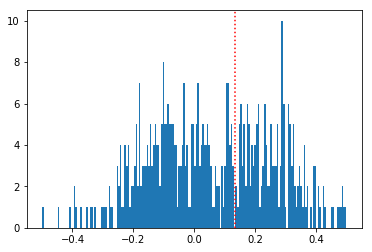

In [86]:
plt.hist(test_img, bins=192)
plt.axvline(x=val, ls=':', color="red")

In [268]:
import cv2
def otsu(xs):
    return np.asarray([img > threshold_otsu(img) for img in xs]).astype(float)
def osi(xs):
#     res = np.ndarray(tuple(xs.shape))
    res = np.ndarray(tuple(xs.shape[:-1]))
    for i in range(len(xs)):
        img = xs[i]
#         img = xs[i].flatten()
#         thresh = threshold_otsu(img)

# #         corner_avg = np.mean(np.hstack([xs[i][-2:, :2], xs[i][:2, -2:], xs[i][:2, :2], xs[i][-2:, -2:]]))
# #         if corner_avg <= thresh:  # Background is dark, digits are light; invert

#         mass_below = sum(img <= thresh)
#         mass_above = sum(img > thresh)
#         if mass_below > mass_above:
#             xs[i] = 0.5 - xs[i]

#         img = resize(np.ascontiguousarray(img), (int(digh * 1.5), int(digw * 1.5))).astype(np.float32)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img = cv2.GaussianBlur(gray,(3,3),0)

#         img = (cv2.Laplacian(img, cv2.CV_32F, ksize=3) / 255)

#         img = ((img + 0.5) * 255).astype(np.float32)
#         img = (cv2.Laplacian(img, cv2.CV_32F, ksize=3) / 255)
    
#         img = ((img + 0.5)).astype(np.float32)
#         img = (cv2.Sobel(img, cv2.CV_32F, 1, 1, ksize=3))

#         img = np.round((img + 0.5) * 255).astype(np.uint8)
#         img = (cv2.Canny(img, 75, 150) / 255) - 0.5
        
#         kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])  # Prewitt
#         kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
#         img_prewittx = cv2.filter2D(img_gaussian, -1, kernelx)
#         img_prewitty = cv2.filter2D(img_gaussian, -1, kernely)
#         img = img_prewittx + img_prewitty
    
#         img = resize(np.ascontiguousarray(img), (digh, digw))

        img = local_contrastive_norm(img.astype(np.float32))

        img_flat = img.flatten()  # Use Otsu's method to invert light-on-dark digits (works if there are fewer digit pixels)
        thresh = threshold_otsu(img_flat)
        mass_below = sum(img_flat <= thresh)
        mass_above = sum(img_flat > thresh)
        if mass_below > mass_above:
            img = 0.5 - img
        
        res[i] = img
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         float_gray = gray.astype(np.float32) / 255.0
#         blur = cv2.GaussianBlur(float_gray, (0, 0), sigmaX=2, sigmaY=2)
#         num = float_gray - blur
#         blur = cv2.GaussianBlur(num*num, (0, 0), sigmaX=25, sigmaY=25)
#         den = cv2.pow(blur, 0.5)
#         gray = num / den
#         cv2.normalize(gray, dst=gray, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
#         return gray - 0.5
    return res

<class 'numpy.ndarray'>
(9, 29, 16, 3)


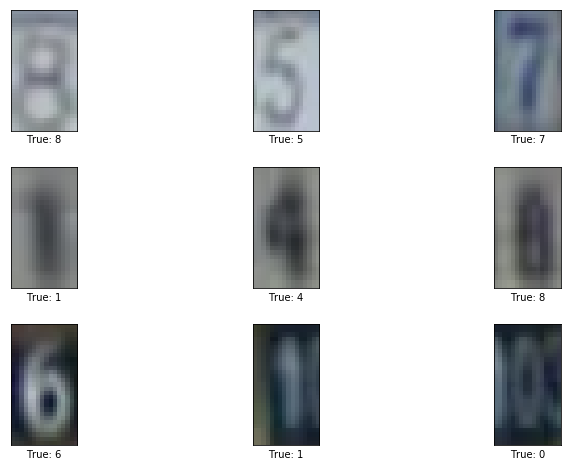

<class 'numpy.ndarray'>
(9, 29, 16)


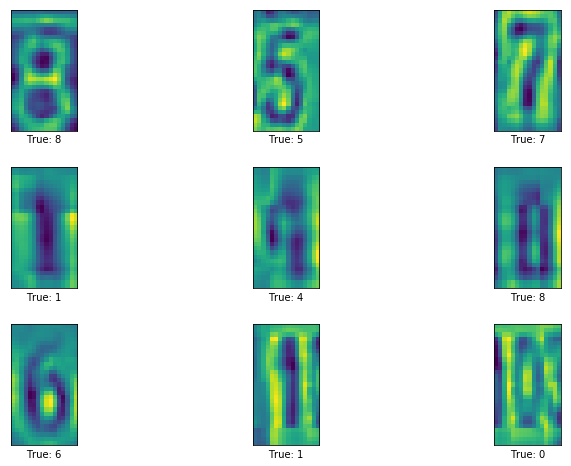

In [269]:
i_start = 1004
plot_images(images=test_imgs[i_start:i_start + 9], cls_true=test_lbls[i_start:i_start + 9], smooth=False)
plot_images(images=osi(test_imgs[i_start:i_start + 9]), cls_true=test_lbls[i_start:i_start + 9], smooth=False)

**Visualise labels**

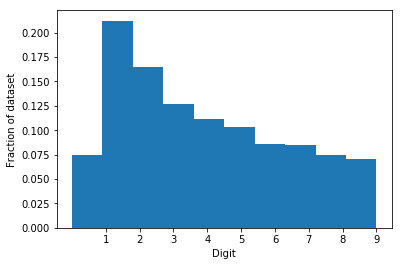

In [20]:
plt.hist(np.hstack([Y_train, Y_test]), bins=10, density=True)
graphs_folder = 'graphs'
plt.xticks([1,2,3,4,5,6,7,8,9])
plt.ylabel("Fraction of dataset")
plt.xlabel("Digit")
plt.savefig(graphs_folder + '/' + "digit_distribution" + '.pdf', format='pdf')

**Shuffle training set**

In [8]:
def shuffle_data(data):
    indices = np.arange(data[0].shape[0]);
    np.random.shuffle(indices)
    return [d[indices] for d in data]
X_train, Y_train = shuffle_data([X_train, Y_train])

**Train and test Softmax regression**

In [9]:
from sklearn.pipeline import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.linear_model import *
from sklearn.decomposition import *
from bayes_opt import BayesianOptimization

In [10]:
X_train_flat = X_train.reshape([-1, digh * digw])
X_test_flat = X_test.reshape([-1, digh * digw])
X_train_flat.shape, X_test_flat.shape

((73252, 464), (26032, 464))

In [18]:
# kernels ['linear', 'poly', 'rbf']: 
# n_minitrain = 30000
n_minitrain = int(X_train.shape[0] * 0.8)
n_minitest = 10000
res = []
for C in [10**0, 10**0.333, 10**0.666, 10**1, 10**1.333, 10**1.666, 10**2]:
    dr_frac = 0.07
    dr = PCA(n_components=int(dr_frac * X_train_flat.shape[1]))
    X_train_lowdim = dr.fit_transform(X_train_flat)
    X_test_lowdim = dr.transform(X_test_flat)

    train_is = np.random.choice(X_train.shape[0], n_minitrain, replace=False)
    m = KNeighborsClassifier(n_neighbors=k)
    m.fit(X_train_lowdim[train_is], Y_train[train_is])
    
    test_is = np.random.choice(X_test.shape[0], n_minitest, replace=False)
    preds = m.predict(X_test_lowdim[test_is])
    res.append(sum(preds == Y_test[test_is]) / n_minitest)
    print(res[-1])

0.72
0.6983333333333334


In [23]:
# n_minitrain = 30000
n_minitrain = int(X_train.shape[0] * 1.0)
n_minitest = int(X_test.shape[0] * 1.0)
def test_softmax(dr_frac, C):
    dr = PCA(n_components=int(dr_frac * X_train_flat.shape[1]))
    X_train_lowdim = dr.fit_transform(X_train_flat)
    X_test_lowdim = dr.transform(X_test_flat)

    train_is = np.random.choice(X_train.shape[0], n_minitrain, replace=False)
    m = SVC(gamma='auto', kernel='rbf', C=C, tol=1e-3)
    m = LogisticRegression(multi_class='multinomial', penalty='l2', C=C, solver='lbfgs', max_iter=3000, tol=1e-5)
    m.fit(X_train_lowdim[train_is], Y_train[train_is])

    test_is = np.random.choice(X_test.shape[0], n_minitest, replace=False)
    preds = m.predict(X_test_lowdim[test_is])
    return sum(preds == Y_test[test_is]) / n_minitest

In [ ]:
# Bounded region of parameter space
optimizer = BayesianOptimization(f=test_softmax, pbounds={'dr_frac': (0.05, 1.0), 'C': (0.1, 100.0)})
optimizer.maximize(init_points=2, n_iter=100)

|   iter    |  target   |     C     |  dr_frac  |
-------------------------------------------------
|  1        |  0.2603   |  50.98    |  0.378    |
|  2        |  0.2579   |  37.3     |  0.5803   |
|  3        |  0.2576   |  100.0    |  0.8011   |
|  4        |  0.2472   |  0.1008   |  0.08953  |
|  5        |  0.2339   |  71.25    |  0.05038  |
|  6        |  0.2557   |  15.13    |  0.9991   |
|  7        |  0.2551   |  49.53    |  0.9992   |
|  8        |  0.2342   |  21.76    |  0.05     |
|  9        |  0.2339   |  89.82    |  0.05     |
|  10       |  0.234    |  7.999    |  0.05     |
|  11       |  0.2341   |  100.0    |  0.05     |
|  12       |  0.255    |  60.41    |  0.9992   |
|  13       |  0.2594   |  0.3453   |  0.999    |
|  14       |  0.255    |  82.21    |  1.0      |
|  15       |  0.234    |  43.15    |  0.05     |
|  16       |  0.2554   |  29.91    |  1.0      |


In [21]:
np.mode([1,2,3,4,4,5,4,5,3])

AttributeError: module 'numpy' has no attribute 'mode'